# A practical guide to the use of training codes for building models, testing data sets and modelling methodology

The aim of this notebook is to provide an overview of the method used to estimate the age of field mosquitoes described in the "A novel approach for age monitoring field anopheles mosquitoes using MALDI Tof and deep learning" article by Mohammad, Naudion et al. This article uses MALDI tof and deep learning to reconstruct the field population structure. Using the Python codes made available, we provide instructions on how to perform regression prediction using them. Python code can be used on any dataset and shows the model architecture directly.    
On the basis of the data table and the datasets we have built, we provide an approach. Please contact Cécile Nabet (cecilenabet7@gmail.com) or Noshine Mohammad (noshine.mohammad@gmail.com) if you are interested in receiving the datasets or more codes.    
Our first step is to describe how the simple CNN discussed in the article can be used to perform the regression. (The reasoning is the same for the TCN).  
The classification and the ranking can be carried out according to the same reasoning. Take the time to read the notebook and the Python file. You will be able to do this step.  
We then describe how to model field mosquito population structure according to a natural scenario. (To get the post-intervention model, you only need to change one parameter).

## Uploading code files

Please take the time to read through the Python files and make sure that you have downloaded the packages that are mentioned.  
Installation codes and documentation links are included.

In [1]:
from models_cnn_tcn_code import *

2023-06-14 18:08:37.033162: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 18:08:37.189346: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-14 18:08:39.315740: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-14 18:08:39.315837: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

CORAL Ordinal version: 0.1.9.dev


## Data loading

The data loading phase is specific to our approach. We have first separated the training set and the test sets. 
We have :
- 1 training set (80% Senegal 1 + 80% Senegal 2)
- 1 Senegal 1 test set (20%)
- 1 Senegal 2 test set (20%)

Datasets features and details (type) : 
- 'jours' : age in days (str) 'J' for age + numbers for age **[TARGET feature]**, 
- 'anatomie' : anatomy + age (str), 
- 'type_donnees' : data type (str), 
- 'sous_fichier' : subfile, specimens file (str), 1 file per specimen, 
- 'pos_plaque' : position plate (str), 
- 'Intensite align msiwarp' : intensity of msiwarp-aligned spectra (array) **[INPUT feature]**, 
- 'Partie anatomique' : anatomical part (str).

**T** : Head  
**P** : Legs  
**TH** : Thorax

In [2]:
from data_loader import *
data_train, test_senegal_1, test_senegal_2 = data_uploading('Anophele_age')

In [3]:
data_train.head()

,jours,anatomie,type_donnees,sous_fichier,pos_plaque,Intensite align msiwarp,Partie anatomique
24,J00,P17,SEN2,J00_P17_SEN2,0_A1,"[0.0, 0.0, 0.0, 108.22549505151551, 99.5794301...",P
1170,J03,TH4,SEN2,J03_TH4_SEN2,0_D10,"[0.0, 0.0, 0.0, 27.97619134607632, 0.0, 0.0, 0...",TH
1563,J28,TH6,SEN2,J28_TH6_SEN2,0_G6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.508072840823...",TH
489,J03,P14,SEN2,J03_P14_SEN2,0_D12,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 90.81...",P
638,J15,TH1,NG,J15_TH1_NG,0_B7,"[0.0, 0.0, 0.0, 0.0, 27.25403428150844, 0.0, 1...",TH


In [4]:
print(set(data_train['anatomie']))
print(set(data_train['jours']))

{'T16', 'T5', 'P13', 'P11', 'T6', 'TH9', 'T9', 'T2', 'TH11', 'TH16', 'TH7', 'T13', 'T14', 'TH15', 'T18', 'T7', 'TH3', 'T11', 'TH5', 'T1', 'P8', 'P12', 'TH13', 'TH2', 'P10', 'TH4', 'TH6', 'TH12', 'T8', 'P4', 'T3', 'P6', 'TH18', 'TH1', 'T15', 'T17', 'P1', 'TH20', 'P5', 'T12', 'TH19', 'T19', 'TH17', 'T20', 'P16', 'TH10', 'P15', 'P3', 'P2', 'P20', 'T10', 'TH14', 'P9', 'P19', 'P17', 'T4', 'P7', 'P18', 'TH8', 'P14'}
{'J17', 'J03', 'J06', 'J15', 'J08', 'J20', 'J10', 'J28', 'J14', 'J00', 'J24'}


### Data processing

To run a regression, we need to encode the target column, which comes from the 'jours' column, indicating the age of the mosquito analysed.To run a regression, we need to encode the target column, which comes from the 'days' column, indicating the age of the mosquito analysed.

In [5]:
def add_encoded_regression_target_feature(row):
    if row['jours'] in ['J00'] :
        return 0
    if row['jours'] in ['J03'] :
        return 3
    if row['jours'] in ['J06'] :
        return 6
    if row['jours'] in ['J08'] :
        return 8
    if row['jours'] in ['J10'] :
        return 10
    if row['jours'] in ['J14'] :
        return 14
    if row['jours'] in ['J15'] :
        return 14
    if row['jours'] in ['J17'] :
        return 17
    if row['jours'] in ['J20'] :
        return 20
    if row['jours'] in ['J24'] :
        return 24
    if row['jours'] in ['J28'] :
        return 28

data_train['regression'] = data_train.apply (lambda row: add_encoded_regression_target_feature(row), axis=1)
test_senegal_1['regression'] = test_senegal_1.apply (lambda row: add_encoded_regression_target_feature(row), axis=1)

### Loading and defining metrics

In [6]:
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
from sklearn.model_selection import KFold, StratifiedKFold
import collections

def naive_roc_auc_score(y_true, y_pred):
    ''' ROC AUC Score adapted for regression (can be used for classification)
    See : https://towardsdatascience.com/how-to-calculate-roc-auc-score-for-regression-models-c0be4fdf76bb
    '''
    num_same_sign = 0
    num_pairs = 0

    for a in range(len(y_true)):
        for b in range(len(y_true)):
            if y_true[a] > y_true[b]:
                num_pairs += 1
                if y_pred[a] > y_pred[b]:
                      num_same_sign += 1
                elif y_pred[a] == y_pred[b]:
                      num_same_sign += .5

    return num_same_sign / num_pairs

from bootstrap_performances import * #Provide the bootstrap function to Calculate Bootstrap Confidence Intervals For Machine Learning Results in Python
#https://machinelearningmastery.com/calculate-bootstrap-confidence-intervals-machine-learning-results-python/

TEST_MAE, TEST_ROC_AUC, BOOTSTRAP_PERF = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list) #to record results

## Training and test phase with a simple CNN model on Senegal 1 test set.

We specify in advance the features that are of interest to us : feature of preprocessed and aligned intensities and target feature.

In [7]:
column = 'Intensite align msiwarp'
target = 'regression'

**⚠️ Warning ! For training, validation and test set preparation, each anatomical part is taken independently.**

Anatomical part :  P
Train label :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17, 18, 20, 21, 22, 23, 24, 26, 27, 29, 30, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 70, 71, 72, 73, 74, 75, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 99, 100, 101, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 120, 121, 122, 123, 126, 127, 128, 129, 130, 131, 134, 135, 136, 137, 138, 139, 140, 143, 144, 146, 148, 149, 150, 151, 152, 153, 154, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 174, 175, 176, 179, 180, 181, 182, 184, 185, 187, 188, 189, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200] size :  162
Y Train clone/non clone :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 

2023-06-13 18:42:47.521319: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-06-13 18:42:47.521350: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-06-13 18:42:47.521688: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


None
Epoch 1/50
11/11 [==============================] - 4s 295ms/step - loss: 6.5646 - mae: 7.0439 - val_loss: 5.3674 - val_mae: 5.8382
Epoch 2/50
11/11 [==============================] - 2s 224ms/step - loss: 3.8166 - mae: 4.2426 - val_loss: 3.6269 - val_mae: 4.0517
Epoch 3/50
11/11 [==============================] - 2s 227ms/step - loss: 2.9970 - mae: 3.4126 - val_loss: 3.2676 - val_mae: 3.7019
Epoch 4/50
11/11 [==============================] - 2s 226ms/step - loss: 2.4842 - mae: 2.9023 - val_loss: 2.9852 - val_mae: 3.4106
Epoch 5/50
11/11 [==============================] - 2s 224ms/step - loss: 2.2678 - mae: 2.6870 - val_loss: 2.8652 - val_mae: 3.2960
Epoch 6/50
11/11 [==============================] - 2s 224ms/step - loss: 2.0736 - mae: 2.4853 - val_loss: 2.7785 - val_mae: 3.2345
Epoch 7/50
11/11 [==============================] - 2s 223ms/step - loss: 1.8152 - mae: 2.2246 - val_loss: 2.4039 - val_mae: 2.8387
Epoch 8/50
11/11 [==============================] - 2s 225ms/step - los

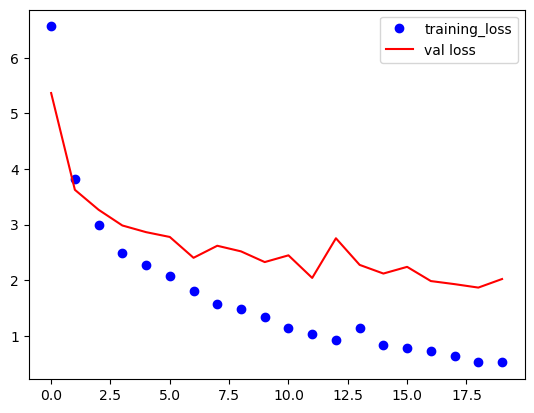

5/5 [==============================] - 0s 61ms/step - loss: 1.8680 - mae: 2.2823
{'loss': 1.8679875135421753, 'mae': 2.282299041748047}
5/5 [==============================] - 0s 53ms/step
pred :  [ 0.  0.  0.  0.  0.  0.  0.  0.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  6.  6.  6.  6.  6.  6.  6.  6.
  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.
  8.  8. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 15. 15. 15. 15. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17.
 17. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17. 20. 20. 20. 20.
 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 24. 24. 24. 24. 24. 24.
 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 28. 28. 28. 28.]
test pred :  [ 2.0078833  0.6267371  1.6047686  0.         1.9157306  0.
  0.         0.         8.581309   5.926413  12.689963  11.820325
  3.5129495  4.006008   5.370055   4.245064   4.6274667  3.777978
  4.796787   4

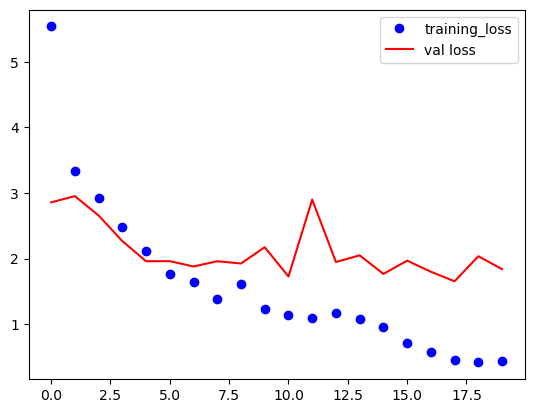

5/5 [==============================] - 0s 54ms/step - loss: 1.6533 - mae: 2.0648
{'loss': 1.6533257961273193, 'mae': 2.064779281616211}
4/4 [==============================] - 0s 58ms/step
pred :  [ 0.  0.  0.  0.  0.  0.  0.  0.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  6.  6.  6.  6.  6.  6.  6.  8.  8.
  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8. 10.
 10. 10. 10. 15. 15. 15. 15. 15. 15. 15. 15. 17. 17. 17. 17. 17. 17. 17.
 17. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17. 20. 20. 20. 20. 20.
 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 24. 24. 24. 24. 24. 24. 24.
 24. 24. 24. 24. 24. 24. 24. 24. 28. 28. 28. 28. 28. 28. 28. 28.]
test pred :  [ 0.          0.5430659   0.64072883  0.          0.          0.
  0.42681852  0.          4.096309    4.8367815   3.8366995   3.8655927
  2.4676428   2.8418093   3.258008    3.6582313   6.085622    3.8780608
  6.11782     3.340013    3.7337499   3.7198102   2.7629423   5.218035
  4.446

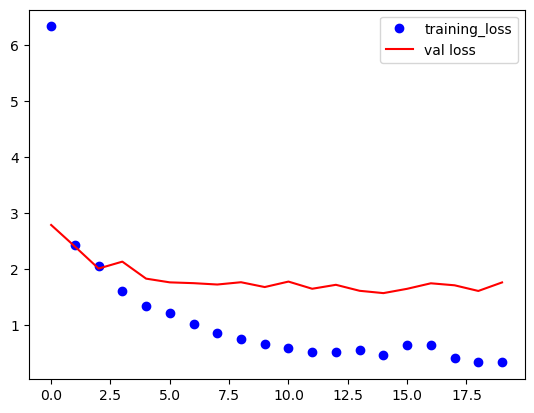

5/5 [==============================] - 0s 47ms/step - loss: 1.5725 - mae: 1.9761
{'loss': 1.572469711303711, 'mae': 1.9761334657669067}
4/4 [==============================] - 0s 55ms/step
pred :  [ 0.  0.  0.  0.  0.  0.  0.  0.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  6.  6.  6.  6.  6.  6.  6.  6.  6.
  6.  8.  8.  8.  8.  8.  8.  8.  8. 10. 10. 10. 10. 10. 10. 10. 10. 15.
 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 17. 17. 17. 17. 17. 17. 17. 17.
 17. 17. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20.
 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24.
 24. 24. 28. 28. 28. 28. 28. 28. 28.]
test pred :  [ 0.         0.         0.         0.         0.         0.
  0.         0.         5.8741937  5.201896   6.210607   6.130409
  2.8853025  3.0299132  3.4044049  2.4310172  3.4219542  3.8401508
  3.3211663  2.240758   1.23459    1.5221956  1.4786022  1.7945026
  2.680751   1.8381588  2.3615224 10.62661    9.491766 

In [8]:
import gc

for part_anatom in ['P', 'T', 'TH']:
    print('Anatomical part : ', part_anatom)
    
    Data_ML = data_train[data_train['Partie anatomique']==part_anatom].copy() #only one anatomical part is extracted at a time
    Data_ML = Data_ML.reset_index(drop=True)

    Data_ML_test = test_senegal_1[test_senegal_1['Partie anatomique']==part_anatom].copy() #same for test set
    Data_ML_test = Data_ML_test.reset_index(drop=True)

    encoder = preprocessing.LabelEncoder()
    encoder.fit(list(Data_ML["sous_fichier"]))
    Data_ML["sous_fichier"] = encoder.transform(Data_ML["sous_fichier"])

    encoder.fit(list(Data_ML_test["sous_fichier"]))
    Data_ML_test["sous_fichier"] = encoder.transform(Data_ML_test["sous_fichier"])

    train = Data_ML[["sous_fichier", column , "jours", target]] #the change has to start from that to make a training, app/validation on different specimens and avoid overfitting...
    y_train = Data_ML[["sous_fichier","jours", target]]
    train_label = []
    y_train_label = []
    for classe in np.unique(train[target]):
        train_label.append(np.unique(train[train[target]==classe]['sous_fichier']))
        y_train_label.append(np.repeat(classe, repeats=len(np.unique(train[train[target]==classe]['sous_fichier']))))
    train_label = np.concatenate(train_label).ravel()
    y_train_label = np.concatenate(y_train_label).ravel()

    test = Data_ML_test[["sous_fichier", column ,  target]]
    y_test = Data_ML_test[["sous_fichier", target]]

    ##Stock_pred = []
    ##Stock_target = []
    ssplit=StratifiedKFold(n_splits=5,shuffle=True, random_state=1234)
    for train_idx_1, test_idx_1 in ssplit.split(train_label, y_train_label):
        train_index_old = train_idx_1
        test_index = test_idx_1     #The train and test specimens are separated beforehand. 
        #for each fold, the specimens in the test set are totally different, so train and test are never the same for each fold

    #A training and validation set is then constructed from the training set.
    X_tr_lab = [train_label[i] for i in train_index_old]
    y_tr_lab= [y_train_label[i] for i in train_index_old]
    X_va_lab = [train_label[i] for i in test_index]
    y_va_lab = [y_train_label[i] for i in test_index]

    print("Train label : ", X_tr_lab, "size : ", len(X_tr_lab))
    print("Y Train clone/non clone : ", y_tr_lab)

    print("Val label : ", X_va_lab, "size : ", len(X_va_lab))
    print("Y val clone/non clone : ", y_va_lab)

    X_tr = train[train.sous_fichier.isin(X_tr_lab)][column]
    y_tr = train[train.sous_fichier.isin(X_tr_lab)][target]
    X_va = train[train.sous_fichier.isin(X_va_lab)][column]
    y_va = train[train.sous_fichier.isin(X_va_lab)][target]
    X_test = test[column]
    y_test = test[target]
    
    
    #The data sets have been built, the training on Senegal 1 + Senegal 2 train set and testing  on the Senegal 1 test set can be carried out
    #change prediction type here if you want to try 'classification' or 'ranking' (Performance metrics must then be modified to reflect accuracy)
    y_test, y_test_pred = run_cnn_tcn_model(X_tr, y_tr, X_va, y_va, X_test, y_test, 'regression', 'cnn', batch_size = 60, len_sp = 17999) 
    
    
    print("pred : ", y_test)
    print("test pred : ", y_test_pred)


    mae_test = mean_absolute_error(y_test,y_test_pred)
    roc_auc_test = naive_roc_auc_score(y_test,y_test_pred)

    print ('Test mae de {}'.format(mae_test))
    print("Roc AUC Score : ", roc_auc_test)

    TEST_MAE[part_anatom].append(mae_test)
    TEST_ROC_AUC[part_anatom].append(roc_auc_test)
    
    ##Stock_pred[part_anatom].append(y_test_pred)
    ##Stock_target[part_anatom].append(y_test)
    
    #Clearing the session removes all the nodes left over from previous models, freeing memory and preventing slowdown.
    # To avoid overfitting
    tf.keras.backend.clear_session() 
    gc.collect()
    tf.random.set_seed(42)
    
    # Clear any logs from previous runs
    #rm -rf ./logs/

    BOOTSTRAP_PERF[part_anatom].append(get_bootstrap_confidence_interval(y_test, y_test_pred,  {'naive roc auc':naive_roc_auc_score}))

## CNN Model performance

In [9]:
table_results_cnn = pd.DataFrame()
table_results_cnn['Metrics'] = ['Test MAE','Roc AUC score', " "]
table_results_cnn = table_results_cnn.set_index('Metrics')
for key in TEST_MAE:
    table_results_cnn['{}'.format(key)] = ["{:.2f}".format(np.round(TEST_MAE[key],2)[0]),
                                           '{0}'.format(np.round(TEST_ROC_AUC[key],2)[0]), 
                                           '[{0},{1}]'.format(np.round(BOOTSTRAP_PERF[key][0]['naive roc auc']['q1'],2), np.round(BOOTSTRAP_PERF[key][0]['naive roc auc']['q3'],2))]
    
table_results_cnn

,P,T,TH
Metrics,,,
Test MAE,2.25,1.99,1.91
Roc AUC score,0.93,0.95,0.96
,"[0.91,0.95]","[0.93,0.96]","[0.94,0.97]"


# Modelisation

Modelling is performed on the Senegal 1 test panel using TCN regression. All anatomical parts were considered to avoid any quantitative problems.

### Output regression treatment

As the regression returns continuous values and we need discrete values for modelling, we have chosen to round the output values of the regression using the estimates obtained by cross validation (CV) on the training set only. (The model was previously trained by CV on the training set on all anatomical parts combined in order to obtain an estimate of the min and max error rates recovered by bootstrap method).

In [10]:
def round_with_CI(part_anatom): #this code can be adaptated to be used on specific anatomical part
    if part_anatom=='all':
        val_min = 1.85 #values recovered from the cross validation on the training panel (only, no test panel)
        val_max = 2.27 
    else :
        raise ValueError('Part_anatom UNKNWON')
    
    return val_min, val_max 

def round_output_with_mae_CI(x, val_min, val_max):
    if x-val_min <= 0 <= x+val_max:
        return 0
    elif x-val_min <= 3 <= x+val_max :
        return 3
    elif x-val_min <= 6 <= x+val_max :
        return 6
    elif x-val_min <= 8 <= x+val_max :
        return 8
    elif x-val_min <= 10 <= x+val_max :
        return 10
    elif x-val_min <= 14 <= x+val_max :
        return 14
    elif x-val_min <= 17 <= x+val_max :
        return 17
    elif x-val_min <= 20 <= x+val_max :
        return 20
    elif x-val_min <= 24 <= x+val_max :
        return 24
    elif x-val_min <= 28 <= x+val_max :
        return 28
    else :
        return 30
    
def change_rvs(x):
    if 0 <= x < 3:
        return 0
    if 3 <= x < 6:
        return 3
    if 6 <= x < 8:
        return 6
    if 8 <= x < 10:
        return 8
    if 10 <= x < 14:
        return 10
    if 14 <= x < 17:
        return 14
    if 17 <= x < 20:
        return 17
    if 20 <= x < 24:
        return 20
    if 24 <= x < 28:
        return 24
    if 28 <= x < 32:
        return 28

### Key functions for modelling

In [11]:
def extract_n_values_specimens(data_t, day, nb_sample): #returns nb_sample individual spectra of specimens using the principle of drawing with delivery of one spectrum per specimen (no duplication)
    data_f_extract_spec = data_t[data_t[target]==day]['sous_fichier'].values
    data_f_extract_spec = np.unique(data_f_extract_spec)
    print(data_f_extract_spec)
    sampled_list = np.random.choice(data_f_extract_spec, nb_sample)
    ind_extract_spec = [data_t[data_t['sous_fichier'].isin([element])].index[np.random.choice(len(data_t[data_t['sous_fichier'].isin([element])]), 1)] for element in sampled_list] #one spectrum per specimen
    #ind_extract_spec = data_t[data_t['sous_fichier'].isin(sampled_list)].index # if we want to take all the spectra of each specimen
    ind_extract_spec = np.concatenate(ind_extract_spec)
    return ind_extract_spec 


#Function that generates the theoretical distribution of the population. 3 statistical models are proposed.
from scipy.stats import gompertz, halflogistic, expon

none_prob = lambda x : 1 # naive_condition_prob
post_intervention_prob = lambda x : x if x < 3 else x/4

def continuous_dist(cohorte_size, scl, prob, stat, survival_prob_function):
    if stat == 'Gompertz': #age dependant
        r = gompertz.rvs(prob, loc=0, scale=scl, size=cohorte_size)
    elif stat == 'Half-logistic': #age dependant
        r = halflogistic.rvs(loc=0, scale=scl, size=cohorte_size)
    elif stat == 'Exponential': #age independant
        r = expon.rvs(loc=0, scale=scl, size=cohorte_size)
    else :
        raise ValueError('Unknown statistical model for modelisation')

    liste = [change_rvs(el) for el in r]
    count = pd.Series(liste).value_counts()
    count = count.sort_index()
    if survival_prob_function=='none_prob':
        val_cumsum = count.cumsum().values
    elif survival_prob_function=='post_intervention_prob':
        val_cumsum = count.values
        val_cumsum = np.array([val_cumsum[i] if i<2 else int(np.ceil(val_cumsum[i]*4)) for i in range(len(val_cumsum))])
        val_cumsum = val_cumsum.cumsum()
        val_cumsum = np.array([x if x<=cohorte_size else cohorte_size for x in val_cumsum])
    else :
        raise ValueError('survival_prob_function UNKNOWN')
    
    dist = (((cohorte_size-val_cumsum)/2)/((cohorte_size-val_cumsum)/2).sum())
  
    return dist

In [12]:
loi_stats = 'Gompertz'
survie_prob = 'none_prob'

part_anatom = 'all'

# For the model display
if loi_stats== 'Gompertz': 
    dist_name = 'gompertz'
elif loi_stats== 'Half-logistic':
    dist_name = 'halflogistic'
elif loi_stats== 'Exponential':
    dist_name = "expon"

### Training phase

Train label :  [0, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 16, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 74, 75, 76, 77, 79, 81, 82, 83, 84, 85, 86, 87, 91, 92, 94, 95, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 112, 113, 114, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 161, 162, 164, 165, 166, 167, 168, 170, 172, 173, 174, 176, 177, 178, 179, 180, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 194, 195, 197, 198, 199, 200, 201, 203, 204, 205, 208, 209, 210, 212, 213, 214, 215, 216, 217, 219, 220, 221, 222, 223, 225, 226, 227, 228, 229, 230, 231, 233, 234, 237, 238, 240, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 256, 258, 259, 260, 262, 263, 264, 265, 266, 268,

2023-06-14 18:09:16.736881: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-06-14 18:09:16.736910: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-06-14 18:09:16.737241: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 17999, 1)]        0         
                                                                 
 batch_normalization (BatchN  (None, 17999, 1)         4         
 ormalization)                                                   
                                                                 
 spatial_dropout1d (SpatialD  (None, 17999, 1)         0         
 ropout1D)                                                       
                                                                 
 tcn (TCN)                   (None, 17999, 3)          132       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 359, 3)           0         
 )                                                               
                                                             

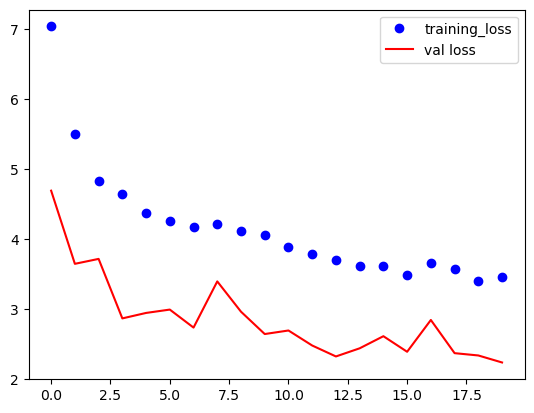

14/14 [==============================] - 2s 113ms/step - loss: 2.2328 - mae: 2.4720


In [13]:
Data_ML = data_train.copy()
Data_ML = Data_ML.reset_index(drop=True)

encoder = preprocessing.LabelEncoder()
encoder.fit(list(Data_ML["sous_fichier"]))
Data_ML["sous_fichier"] = encoder.transform(Data_ML["sous_fichier"])
len_sp = 17999


train = Data_ML[["sous_fichier", column , "jours", target]]
y_train = Data_ML[["sous_fichier","jours", target]]
train_label = []
y_train_label = []
for classe in np.unique(train[target]):
    train_label.append(np.unique(train[train[target]==classe]['sous_fichier']))
    y_train_label.append(np.repeat(classe, repeats=len(np.unique(train[train[target]==classe]['sous_fichier']))))
train_label = np.concatenate(train_label).ravel()
y_train_label = np.concatenate(y_train_label).ravel()


ssplit=StratifiedKFold(n_splits=5,shuffle=True, random_state=1234)
for train_idx_1, test_idx_1 in ssplit.split(train_label, y_train_label):
    train_index_old = train_idx_1
    test_index = test_idx_1
    
X_tr_lab = [train_label[i] for i in train_index_old]
y_tr_lab= [y_train_label[i] for i in train_index_old]
X_va_lab = [train_label[i] for i in test_index]
y_va_lab = [y_train_label[i] for i in test_index]

print("Train label : ", X_tr_lab, "size : ", len(X_tr_lab))
print("Y Train clone/non clone : ", y_tr_lab)

print("Val label : ", X_va_lab, "size : ", len(X_va_lab))
print("Y val clone/non clone : ", y_va_lab)

X_tr = train[train.sous_fichier.isin(X_tr_lab)][column]
y_tr = train[train.sous_fichier.isin(X_tr_lab)][target]
X_va = train[train.sous_fichier.isin(X_va_lab)][column]
y_va = train[train.sous_fichier.isin(X_va_lab)][target]

training_data = np.array([spectre[:len_sp] for spectre in X_tr.values])
validation_data = np.array([spectre[:len_sp] for spectre in X_va.values])

y_training_data = y_tr
y_validation_data = y_va

X_train = training_data
y_train = np.array(y_training_data.values.astype('float32').reshape(-1,1))
print(f'Train data dimensions: {X_train.shape}, {y_train.shape}')

X_va = validation_data
y_va = np.array(y_validation_data.values.astype('float32').reshape(-1,1))
print(f'Validation data dimensions: {X_va.shape}, {y_va.shape}')


# TCN #########################################################

inputs = Input(shape=(X_train.shape[1], 1))
x = BatchNormalization(momentum=0.99)(inputs)
x = SpatialDropout1D(0.3)(x)
x = TCN(nb_filters=3, kernel_size=10, nb_stacks=1, dilations=[10], padding='same',use_skip_connections=True,
        dropout_rate=0.3, return_sequences=True)(x)
x = MaxPool1D(pool_size=50)(x)
x = Flatten()(x)

x = Dense(512,activation=tf.keras.layers.PReLU(), kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
x = Dense(128,activation=tf.keras.layers.PReLU(), kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
x = Dense(512,activation=tf.keras.layers.PReLU(), kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
x = LayerNormalization()(x)
predictions = Dense(1, activation='relu')(x)


###############################################################

model = Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer='adam', loss='huber_loss', metrics=['mae'])
print(model.summary())


# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_mae', min_delta=0, 
                        patience=20, verbose=1, mode='auto',
                        baseline=0, restore_best_weights=True)


# fit model
EPOCH = 50 
BATCH = 80

History = model.fit(X_train, y_train,
                          epochs=EPOCH,
                          batch_size=BATCH,
                          validation_data=(X_va, y_va),
                          shuffle=True,verbose=1,
                          callbacks=[early_stop])
      
history_dict=History.history
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.plot(loss_values,'bo',label='training_loss')
plt.plot(val_loss_values,'r',label='val loss')
plt.legend(loc = 'upper right')

plt.show()

results = model.evaluate(X_va,  y_va, verbose = 1)
results = dict(zip(model.metrics_names,results))

#### Testing phase with modelling functions

In [23]:
##TEST_MAE, TEST_ACCURACY = collections.defaultdict(list), collections.defaultdict(list)
from collections import Counter

all_histograms_target = []
all_histograms_pred = []

Data_ML_test = test_senegal_1.copy()
Data_ML_test = Data_ML_test.reset_index(drop=True)
encoder = preprocessing.LabelEncoder()
encoder.fit(list(Data_ML_test["sous_fichier"]))
Data_ML_test["sous_fichier"] = encoder.transform(Data_ML_test["sous_fichier"])
test = Data_ML_test[["sous_fichier", column , "jours", target]]
y_test = Data_ML_test[["sous_fichier","jours", target]]

##Stock_pred = []
##Stock_target = []


m=100 #number of simulations

for i in range(m):
    
    cohorte_size = 10000 #Cohort size to build a solid theoretical population structure. Not to be confused with the sample size for the test!
    n = 100 #sample size MOST IMPORTANT
    
    
    ########################################### Construction of the theoretical test set whose distribution will follow the defined statistical model (Gompertz) and the determined sample size (100)
    dist_gomp = continuous_dist(cohorte_size,18,.8, loi_stats ,survie_prob) ##continuous_dist(cohorte_size,8,.6, loi_stats ,survie_prob)
    values = np.random.choice([0,3,6,8,10,14,17,20,24,28], size=n, p=dist_gomp)
    values = [element for element in values]
    print(Counter(values))
    ind_to_extract = [extract_n_values_specimens(test, elem, Counter(values)[elem]) for elem in Counter(values)]
    
    X_test = test[column]
    y_test = test[target]
    
    test_data = np.array([np.asarray(spectre[:len_sp]).astype('float32') for spectre in X_test.values])
    y_test_data = y_test
    
    X_test = np.stack(test_data)
    y_test = np.array(y_test_data.values.astype('float32').reshape(-1,1))
    print(f'Test data dimensions: {X_test.shape}, {y_test.shape}')


    test_index_new = np.concatenate(ind_to_extract)

    X_test_new = X_test[test_index_new]
    y_test_new = y_test[test_index_new]

    test_data_new = np.array([spectre[:len_sp] for spectre in X_test_new])
    print(f'Test data dimensions: {test_data_new.shape}, {y_test_new.shape}')
    
    print(Counter(values))                         
    print('Target : ', y_test_new.ravel())
    ###########################################
    
    #Population according to the law of Gompertz, whose age is estimated by the model on the basis of the spectra.
    labels = model.predict(test_data_new)
    
    val_mae_min,  val_mae_max= round_with_CI(part_anatom)
    print('Prediction : ', labels.ravel())
    labels = [round_output_with_mae_CI(el, val_mae_min,  val_mae_max) for el in labels ]
    print('Round prediction : ', labels)

    # What is our accuracy?
    print(np.mean(labels == y_test_new.ravel()))
    
    ##TEST_ACCURACY[part_anatom].append(np.mean(labels == y_test_new.ravel()))

    print(mean_absolute_error(y_test_new.ravel(),labels))
    
    #################################################################################################################
    
    ##Stock_pred.append(labels)
    ##Stock_target.append(y_test_new.ravel())
    
    print('#################################################################################################################')
    
    
    all_histograms_target.append(np.array(np.bincount(y_test_new.ravel().astype('int64'), minlength=29)))  #theorical population recorded
    all_histograms_pred.append(np.array(np.bincount(labels, minlength=29))) #rounded predictions recorded

    # Clear any logs from previous runs
    #rm -rf ./logs/ 
    print('Iteration : ', i)

Counter({0: 19, 6: 18, 8: 17, 3: 15, 10: 11, 14: 8, 17: 5, 20: 5, 28: 1, 24: 1})
[21 22 23 24 25 26 27]
[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[40 41 42 43 44 45 46]
[53 54 55 56 57 58 59 60 61 62 63 64 65 66 67]
[28 29 30 31 32 33 34 35 36 37 38 39]
[0 1 2 3 4 5]
[68 69 70 71 72 73 74 75 76 77 78 79]
[94 95 96 97 98]
[47 48 49 50 51 52]
[80 81 82 83 84 85 86 87 88 89 90 91 92 93]
Test data dimensions: (385, 17999), (385, 1)
Test data dimensions: (100, 17999), (100, 1)
Counter({0: 19, 6: 18, 8: 17, 3: 15, 10: 11, 14: 8, 17: 5, 20: 5, 28: 1, 24: 1})
Target :  [ 6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 17. 17. 17. 17. 17.  8.  8.  8.  8.  8.
  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 20. 20. 20. 20. 20.
 28. 14. 14. 14. 14. 14. 14. 14. 14. 24.]
4/4 [===============

In [24]:
all_histograms_target = np.asarray(all_histograms_target)
mean_histogram_target = np.sum(all_histograms_target, axis=0)/np.sum(all_histograms_target)
mean_histogram_target = np.cumsum(mean_histogram_target[[0,3,6,8,10,14,17,20,24,28]])

all_histograms_pred= np.asarray([el[:29] for el in all_histograms_pred])
mean_histogram_pred = np.asarray([el/np.sum(el) for el in all_histograms_pred])
mean_histogram_pred = np.asarray([np.cumsum(el[[0,3,6,8,10,14,17,20,24,28]]) for el in mean_histogram_pred])

In [25]:
from sklearn.metrics import r2_score
from sklearn.metrics import auc
liste_perf_tirage = np.array([auc(mean_histogram_target,elem) for elem in mean_histogram_pred])

### Modelisation plot

#### Natural mortality scenario

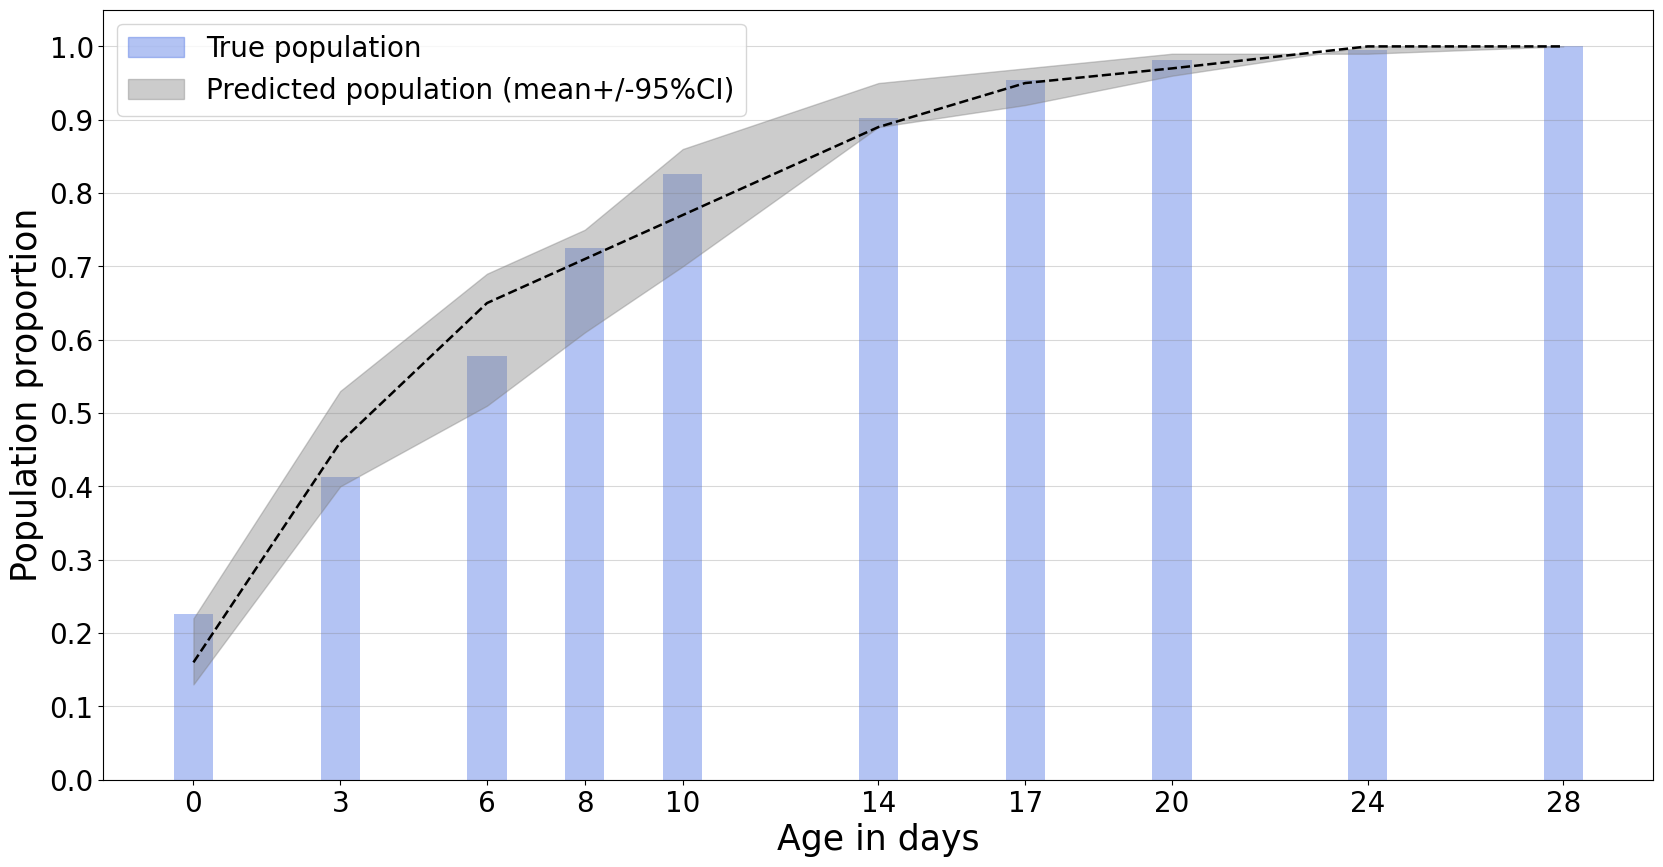

In [31]:
import scipy
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import scipy.stats

fig, ax = plt.subplots(figsize=(20,10), facecolor="white") 
fig.canvas.draw()
ax.set_facecolor('white')

# Parameters of the law
dist = getattr(scipy.stats, dist_name)


ax.bar(np.array([0,3,6,8,10,14,17,20,24,28]), mean_histogram_target, alpha=0.4,width = .8, label = 'Population', color = "royalblue")
ax.set_xticks([0,3,6,8,10,14,17,20,24,28])
plt.plot(np.array([0,3,6,8,10,14,17,20,24,28]),mean_histogram_pred[list(liste_perf_tirage).index(np.percentile(list(liste_perf_tirage), 50, interpolation='nearest'))],'--',  color='black', linewidth=1.8)
plt.fill_between(np.array([0,3,6,8,10,14,17,20,24,28]),mean_histogram_pred[list(liste_perf_tirage).index(np.percentile(list(liste_perf_tirage), 97, interpolation='nearest'))], mean_histogram_pred[list(liste_perf_tirage).index(np.percentile(list(liste_perf_tirage), 1, interpolation='nearest'))], color='gray',alpha=.4)


plt.xlabel('Age in days', fontsize=25, color = 'k')
plt.ylabel('Population proportion', fontsize=25, color = 'k')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(axis='y', color = 'gray', alpha=.3)
plt.xticks([0,3,6,8,10,14,17,20,24,28], fontsize=25,color = 'k')
plt.yticks(fontsize=20, color = 'k')
ax.set_yticks(np.arange(0,105,10)/100)
ax.set_xticklabels(["0", "3", "6", "8", "10", "14", "17", "20", "24", "28"], fontsize=20)


pop_patch_pre = mpatches.Patch(color="royalblue", label="True population", alpha = .4)
pop_patch_IC = mpatches.Patch(color="gray", label='Predicted population (mean+/-95%CI)', alpha = .4)
plt.legend(loc='upper left', facecolor="white", fontsize=20, handles= [pop_patch_pre, pop_patch_IC])
plt.show() 